In [ ]:
pip install numpy pandas scikit-learn xgboost


In [ ]:
pip install --upgrade setuptools

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [6]:
# 1) Load datasets
train_df = pd.read_csv('train_panel_processed.csv')
test_df  = pd.read_csv('test_panel_processed.csv')

# 2) Separate features and target (assumes target column is named 'target')
target = 'FGAP_STRESS_T+1' if 'FGAP_STRESS_T+1' in train_df.columns else 'FGAP_STRESS_TP1'

# Separate features and target
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [ ]:





# 3) Unified sample weights for ALL models (equivalent ratio to XGBoost's scale_pos_weight)
#    spw = n_negative / n_positive
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = n_neg / max(n_pos, 1)  # avoid division by zero
# Per-sample weights: class 0 -> 1.0, class 1 -> spw
sample_weight = np.where(y_train == 1, spw, 1.0)

print(f"Class counts -> 0: {n_neg}, 1: {n_pos}; scale_pos_weight (for ref): {spw:.4f}")

# 4) Define models (NO class_weight / scale_pos_weight here; we use sample_weight during fit)
models = {
    'Logistic Regression': (
        LogisticRegression(
            max_iter=2000,
            solver='liblinear',   # supports l1 & l2
            random_state=42
        ),
        {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(
            random_state=42
        ),
        {
            'n_estimators': [200, 500, 800],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            # We omit scale_pos_weight intentionally to rely on sample_weight for fairness
            eval_metric='logloss',
            tree_method='hist',
            random_state=42,
            n_jobs=-1
        ),
        {
            'n_estimators': [200, 400, 800],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.03, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_lambda': [1, 5, 10],   # L2 regularization
            'reg_alpha': [0, 0.5, 1],   # L1 regularization
            }
        )
    }

# 5) Stratified CV to preserve class ratio in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6) Run GridSearchCV for each model with the SAME sample_weight input
results = {}

for name, (model, params) in models.items():
    print(f"=== Running GridSearchCV for {name} ===")
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        refit=True
    )

    # Pass per-sample weights so all models see the same weighting
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})

    best_model = grid.best_estimator_
    print(f"Best Params for {name}: {grid.best_params_}")

    # Evaluate on test set
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    # Compute ROC AUC and a threshold-optimized version (Youden's J)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    opt_idx = np.argmax(tpr - fpr)
    opt_thr = thr[opt_idx]
    y_pred_opt = (y_proba >= opt_thr).astype(int)

    res = {
        'Best Params': grid.best_params_,
        'ROC AUC (0.5 thr)': auc,
        'Classification Report (0.5 thr)': classification_report(y_test, y_pred),
        'Confusion Matrix (0.5 thr)': confusion_matrix(y_test, y_pred),
        'Optimal Threshold': float(opt_thr),
        'Classification Report (opt thr)': classification_report(y_test, y_pred_opt),
        'Confusion Matrix (opt thr)': confusion_matrix(y_test, y_pred_opt)
    }
    results[name] = res

# 7) Display results
for name, res in results.items():
    print(f"================ {name} ================")
    print(f"Best Params: {res['Best Params']}")
    print(f"ROC AUC (0.5 thr): {res['ROC AUC (0.5 thr)']:.4f}")
    print("Classification Report (0.5 thr):", res['Classification Report (0.5 thr)'])
    print("Confusion Matrix (0.5 thr):", res['Confusion Matrix (0.5 thr)'])
    print(f"Optimal Threshold: {res['Optimal Threshold']:.4f}")
    print("Classification Report (opt thr):", res['Classification Report (opt thr)'])
    print("Confusion Matrix (opt thr):", res['Confusion Matrix (opt thr)'])

# 8) TYPE I & TYPE II ERROR ANALYSIS + COST-SENSITIVE THRESHOLDING
# Type I error (False Positive): predict 1 but true 0
# Type II error (False Negative): predict 0 but true 1

from dataclasses import dataclass

@dataclass
class ErrMetrics:
    threshold: float
    fp: int
    fn: int
    tp: int
    tn: int
    type1_rate: float  # FPR = FP / (FP + TN)
    type2_rate: float  # FNR = FN / (FN + TP)


def compute_err_metrics(y_true, y_proba, thr):
    from sklearn.metrics import confusion_matrix
    y_pred = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    type1_rate = fp / max(fp + tn, 1)
    type2_rate = fn / max(fn + tp, 1)
    return ErrMetrics(threshold=float(thr), fp=int(fp), fn=int(fn), tp=int(tp), tn=int(tn),
                      type1_rate=float(type1_rate), type2_rate=float(type2_rate))


def search_threshold_min_cost(y_true, y_proba, cost_fp=1.0, cost_fn=1.0, n_grid=1000):
    # Sweep thresholds on sorted unique probabilities (or linspace as fallback)
    import numpy as np
    uniq = np.unique(y_proba)
    if len(uniq) > n_grid:
        grid = np.linspace(0.0, 1.0, n_grid)
    else:
        grid = uniq
    best = None
    best_cost = float('inf')
    for thr in grid:
        em = compute_err_metrics(y_true, y_proba, thr)
        cost = cost_fp * em.type1_rate + cost_fn * em.type2_rate
        if cost < best_cost:
            best_cost = cost
            best = (thr, em)
    return best  # (threshold, ErrMetrics)

# Collect y_true and y_proba for each model to analyze Type I/II
# Re-run predictions with stored best estimators to keep memory light
summary_rows = []

for name, (model, params) in models.items():
    # Fit again on the whole train set using best params found above (refit=True already done)
    # We'll reuse the already refitted estimator via GridSearchCV if available.
    # For simplicity, re-create GridSearchCV to fetch best estimator from 'results' context.
    # But we already have metrics in 'results'; let's recompute probabilities with the best estimator by re-training:
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=0,
        refit=True
    )
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})
    best_est = grid.best_estimator_
    y_proba = best_est.predict_proba(X_test)[:, 1]

    # 8a) Metrics at default 0.5 threshold
    em_05 = compute_err_metrics(y_test, y_proba, 0.5)

    # 8b) Metrics at Youden's J optimal threshold
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    opt_idx = np.argmax(tpr - fpr)
    opt_thr = thr[opt_idx]
    em_opt = compute_err_metrics(y_test, y_proba, opt_thr)

    # 8c) Cost-sensitive threshold to reduce Type I vs Type II
    COST_FP = 1.0  # <--- chỉnh nếu muốn phạt FP mạnh hơn
    COST_FN = 1.0  # <--- chỉnh nếu muốn phạt FN mạnh hơn
    thr_cs, em_cs = search_threshold_min_cost(y_test, y_proba, COST_FP, COST_FN)

    # Save compact summary row
    summary_rows.append({
        'Model': name,
        'Thr@0.5': 0.5,
        'Type I rate@0.5 (FPR)': round(em_05.type1_rate, 4),
        'Type II rate@0.5 (FNR)': round(em_05.type2_rate, 4),
        'Thr@Youden': round(float(opt_thr), 4),
        'Type I rate@Youden': round(em_opt.type1_rate, 4),
        'Type II rate@Youden': round(em_opt.type2_rate, 4),
        'Thr@CostSensitive': round(float(thr_cs), 4),
        'Type I rate@CS': round(em_cs.type1_rate, 4),
        'Type II rate@CS': round(em_cs.type2_rate, 4)
    })

# 9) Print a consolidated table of thresholds and Type I/II rates
try:
    import pandas as pd
    summary_df = pd.DataFrame(summary_rows)
    print("===== Threshold & Error Summary (Type I/II) =====")
    print(summary_df.to_string(index=False))
except Exception as e:
    print("Could not render summary table:", e)

# 10) Also print the BEST PARAMS of all models in one place for convenience
print("===== Best Params (recomputed here for display) =====")
for name, (model, params) in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        verbose=0,
        refit=True
    )
    grid.fit(X_train, y_train, **{'sample_weight': sample_weight})
    print(f"{name}: {grid.best_params_}")


Class counts -> 0: 726, 1: 219; scale_pos_weight (for ref): 3.3151
=== Running GridSearchCV for Logistic Regression ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for Logistic Regression: {'C': 1, 'penalty': 'l1'}
=== Running GridSearchCV for Random Forest ===
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
=== Running GridSearchCV for XGBoost ===
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0}
================ Logistic Regression ================
Best Params: {'C': 1, 'penalty': 'l1'}
ROC AUC (0.5 thr): 0.8750
Classification Report (0.5 thr):               precision    recall  f1-score   support

           0       1.00      

In [5]:
pip install shap matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 547.8/547.8 kB 5.0 MB/s  0:00:00
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cach


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import xgboost
import shap
print("xgboost version:", xgboost.__version__)
print("shap version:", shap.__version__)

C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


xgboost version: 3.0.5
shap version: 0.49.1


In [1]:
pip install xgboost==3.0.5

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 3.5 MB/s eta 0:00:17
   - -------------------------------------- 1.6/56.8 MB 5.0 MB/s eta 0:00:12
   - -------------------------------------- 2.6/56.8 MB 4.9 MB/s eta 0:00:12
   -- ------------------------------------- 3.4/56.8 MB 4.6 MB/s eta 0:00:12
   --- ------------------------------------ 4.5/56.8 MB 4.6 MB/s eta 0:00:12
   --- ------------------------------------ 5.5/56.8 MB 4.6 MB/s eta 0:00:12
   ---- ----------------------------------- 6.3/56.8 MB 4.5 MB/s eta 0:00:12
   ---- ----------------------------------- 6.8/56.8 MB 4.6 MB/s eta 0:00:11
   ----- ---------------------------------- 8.1/56.8 MB 4.6 MB/s eta 0:00:11
   ------ --------------------------------- 9.4/56.8 MB 4.6 MB/s eta 0:00:11
   ------- -------------------------------- 10.2/56.8 MB 4.5 MB/s eta 0:00:11
   -


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import shap
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

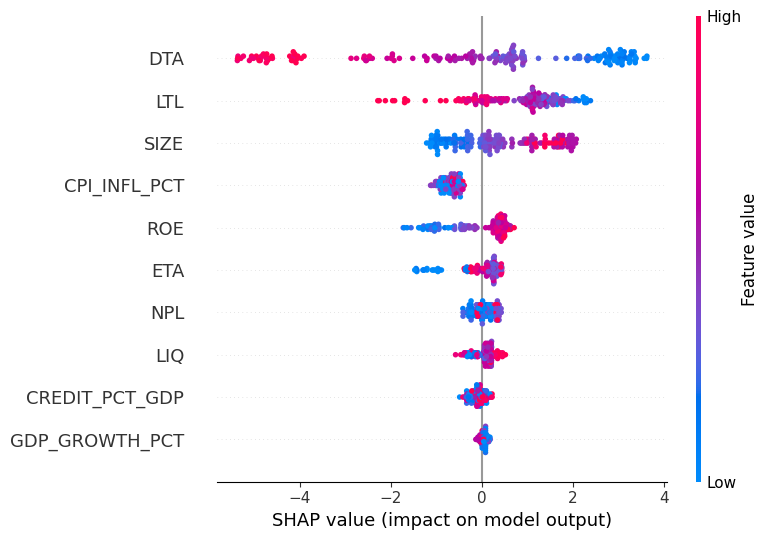

In [ ]:
# using SHAP
best_params = {
    'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3,
    'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 1.0
}
xgb_clf = XGBClassifier(
    **best_params,
    random_state=42,
    tree_method="hist",
    enable_categorical=False,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)    

X_te = X_test

xgb_explainer = shap.TreeExplainer(xgb_clf)
xgb_shap_values = xgb_explainer.shap_values(X_te)




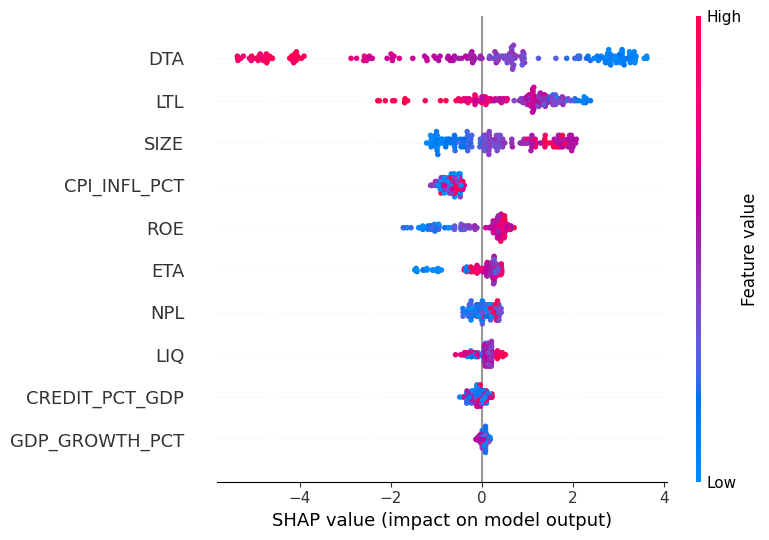

In [9]:
# 1. SHAP ANALYSIS - TÌM BIẾN QUAN TRỌNG
shap.summary_plot(xgb_shap_values, X_te)

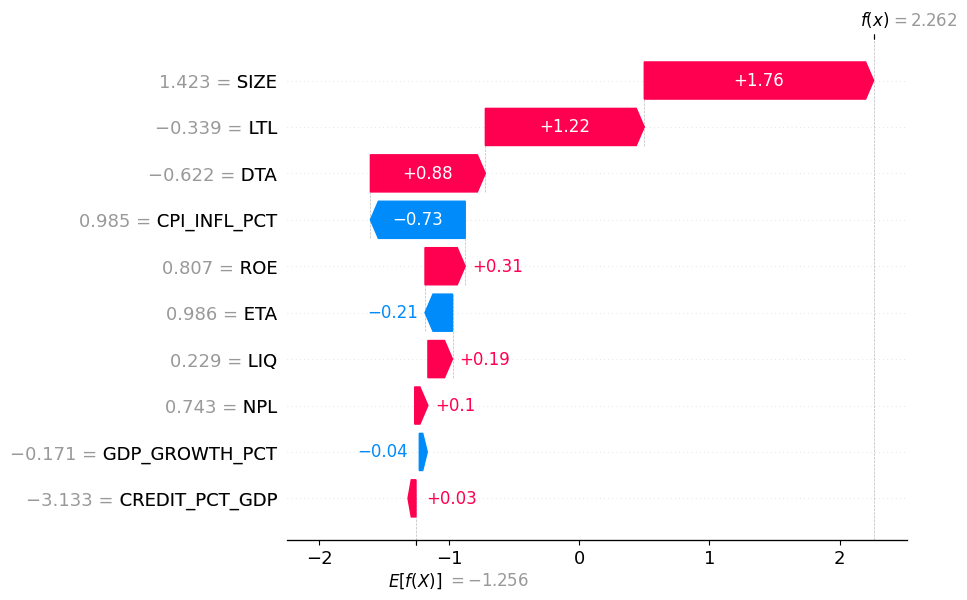

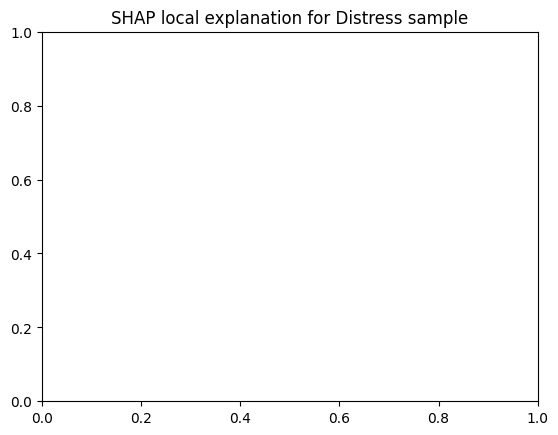

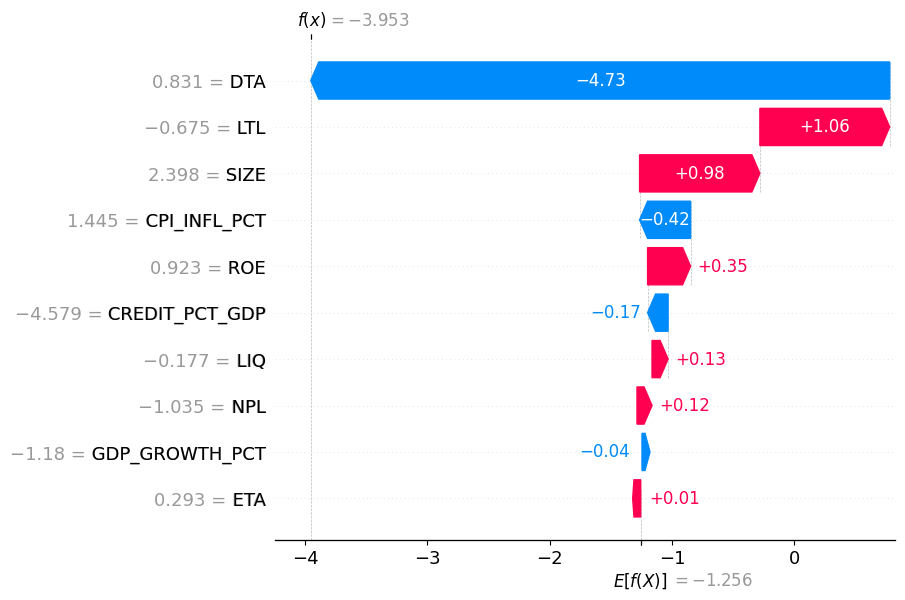

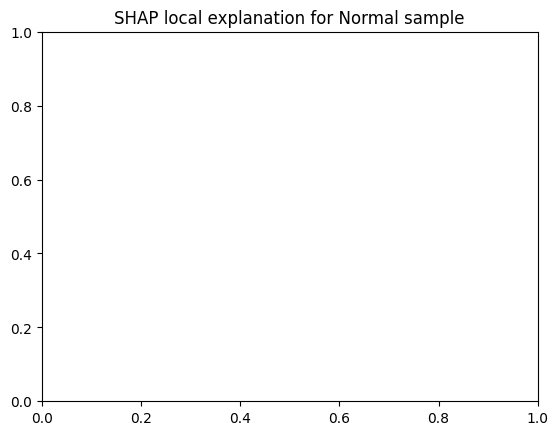

In [11]:
# Chọn ngẫu nhiên 1 sample từ financial distress (y=1) và normal (y=0)
sample_distress = X_test[y_test==1].sample(1, random_state=42)
sample_normal = X_test[y_test==0].sample(1, random_state=42)

# Visualize explanation cho từng cá thể
for sample, label in zip([sample_distress, sample_normal], ['Distress', 'Normal']):
    shap.waterfall_plot(shap.Explanation(values=xgb_explainer(sample.values).values[0],
                                         base_values=xgb_explainer(sample.values).base_values[0],
                                         data=sample.values[0],
                                         feature_names=sample.columns),
                        max_display=10, show=True)
    plt.title(f"SHAP local explanation for {label} sample")
    plt.show()

C

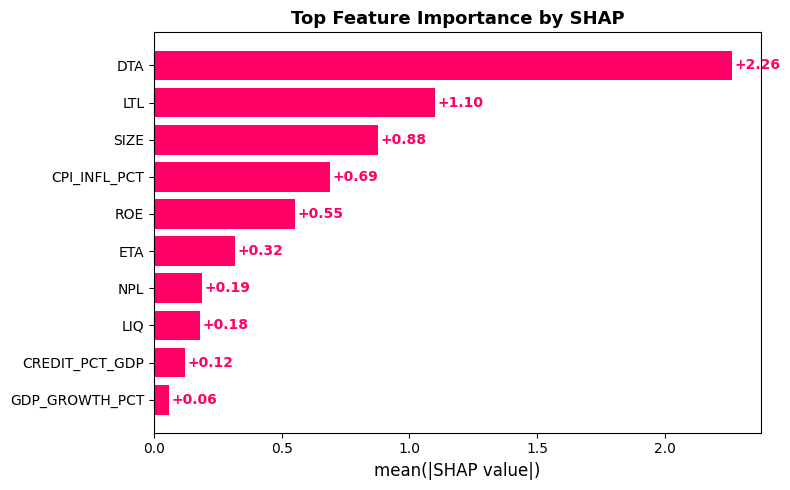

In [20]:
# === SHAP BAR PLOT ===
import matplotlib.pyplot as plt
import numpy as np

# 1. Tính giá trị tuyệt đối trung bình của SHAP cho từng biến
feature_importance = np.abs(xgb_shap_values).mean(0)
feature_names = X_te.columns.tolist()

# 2. Sắp xếp giảm dần
sorted_idx = np.argsort(feature_importance)[::-1]
top_n = 10 
top_features = [feature_names[i] for i in sorted_idx[:top_n]]
top_values = feature_importance[sorted_idx[:top_n]]

# 3. Vẽ biểu đồ thanh ngang
plt.figure(figsize=(8, 5))
bars = plt.barh(top_features[::-1], top_values[::-1], color="#FF0066")
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.title("Top Feature Importance by SHAP", fontsize=13, fontweight="bold")

# 4. Gắn nhãn + giá trị ở cuối mỗi thanh
for i, v in enumerate(top_values[::-1]):
    plt.text(v + 0.01, i, f"+{v:.2f}", color="#FF0066", fontweight="bold", va="center")

plt.tight_layout()
plt.show()

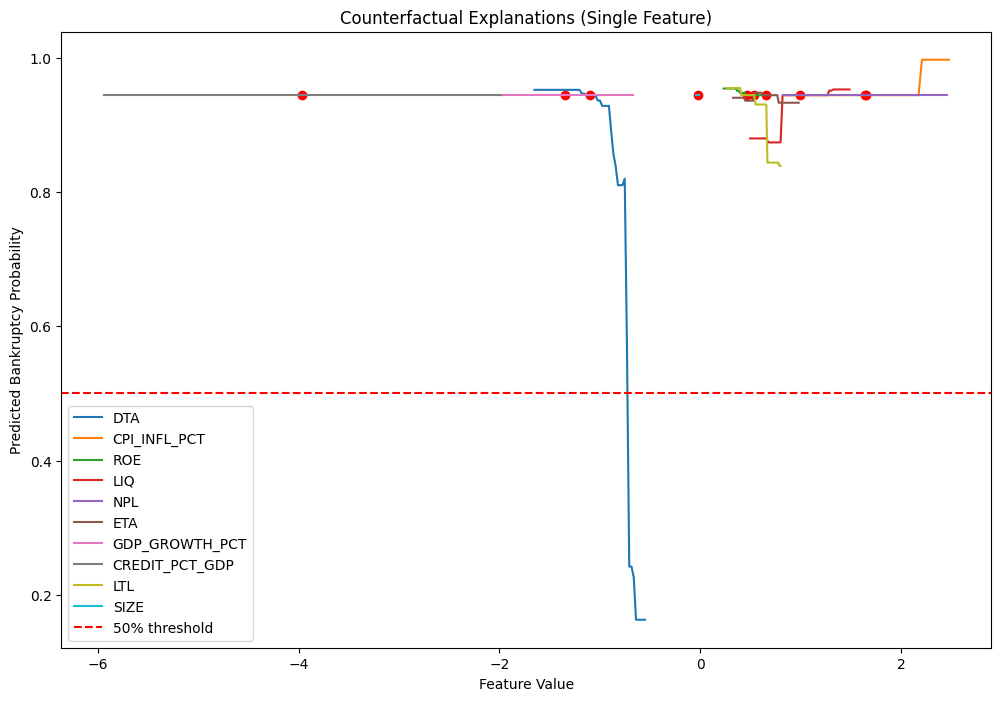

In [14]:


# Giả sử bạn có:
# X_train, X_test, y_train, y_test
# lgb_model: LightGBM classifier đã train

# 1. Chọn sample A (ví dụ sample đầu tiên từ nhóm financial distress)
sample_idx = X_test[y_test==0].index[0]
x_sample = X_test.loc[[sample_idx]].copy()

# 2. Tạo SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(x_sample)

# 3. Xác định top features quan trọng dựa trên SHAP
shap_importance = np.abs(shap_values.values).flatten()
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_value': shap_importance
}).sort_values(by='shap_value', ascending=False)

top_features = feature_importance['feature'].tolist()

# 4. Tạo counterfactual dựa trên từng feature
counterfactual_probs = []

for feature in top_features:
    original_value = x_sample[feature].values[0]
    
    # Tạo dãy giá trị thử nghiệm quanh giá trị gốc
    if np.issubdtype(x_sample[feature].dtype, np.number):
        test_values = np.linspace(original_value*0.5, original_value*1.5, 50)
    else:
        test_values = X_test[feature].unique()
    
    probs = []
    for val in test_values:
        x_temp = x_sample.copy()
        x_temp[feature] = val
        pred_prob = xgb_clf.predict_proba(x_temp)[0][1]  # xác suất phá sản
        probs.append(pred_prob)
    
    counterfactual_probs.append((feature, test_values, probs))

# 5. Vẽ biểu đồ counterfactual cho từng feature
plt.figure(figsize=(12, 8))
for feature, test_values, probs in counterfactual_probs:
    plt.plot(test_values, probs, label=feature)
    # đánh dấu giá trị gốc
    plt.scatter(x_sample[feature].values[0], xgb_clf.predict_proba(x_sample)[0][1], color='red')

plt.axhline(0.5, color='red', linestyle='--', label='50% threshold')
plt.xlabel('Feature Value')
plt.ylabel('Predicted Bankruptcy Probability')
plt.title('Counterfactual Explanations (Single Feature)')
plt.legend()
plt.show()


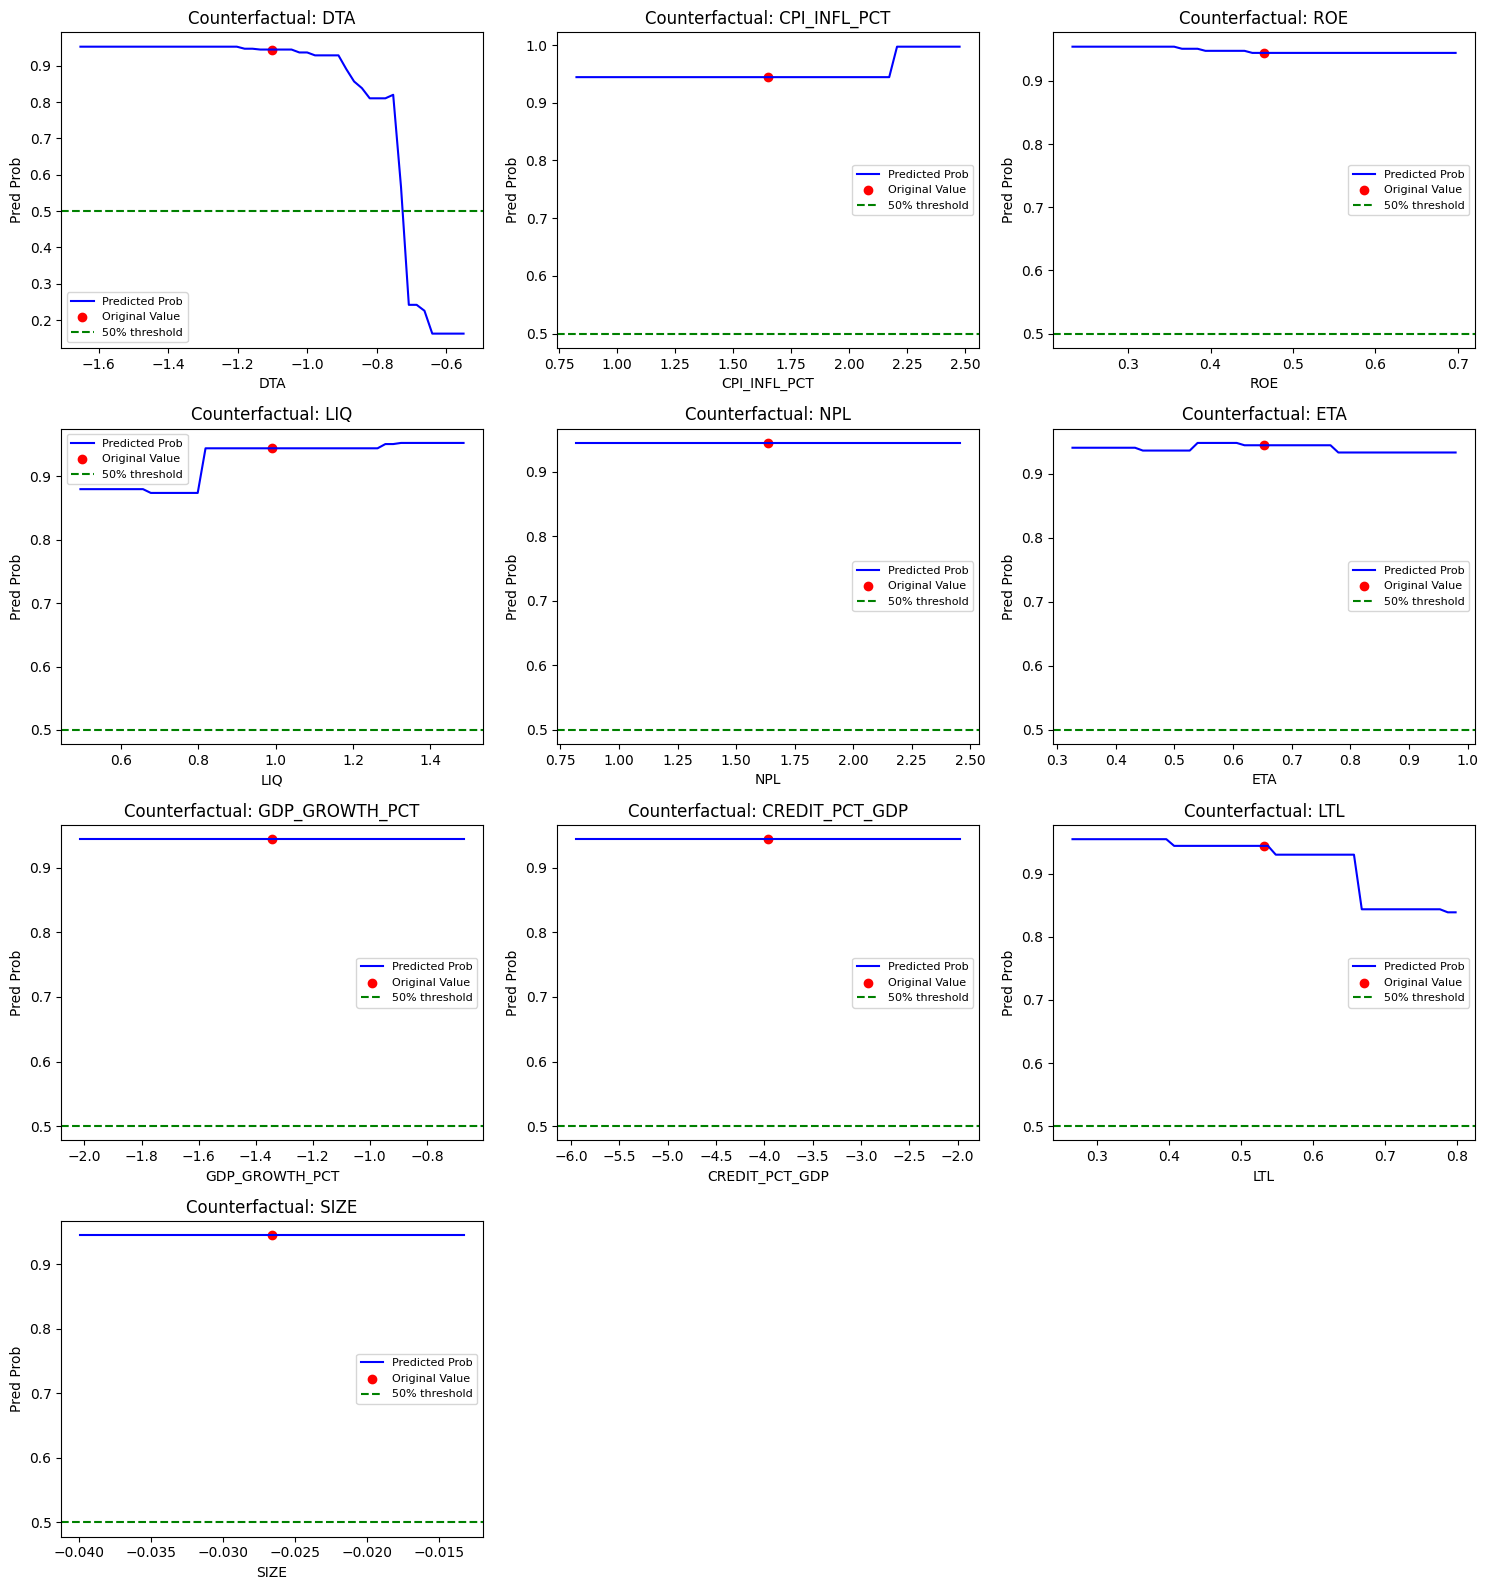

In [19]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# =========================
# 1. Chọn sample
# =========================
# Chọn sample đầu tiên từ nhóm financial distress (y=0)
sample_idx = X_test[y_test==0].index[0]
x_sample = X_test.loc[[sample_idx]].copy()

# =========================
# 2. Tạo SHAP explainer
# =========================
explainer = shap.TreeExplainer(xgb_clf)  # dùng LightGBM model
shap_values = explainer(x_sample)

# =========================
# 3. Xác định top features quan trọng
# =========================
shap_importance = np.abs(shap_values.values).flatten()
feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_value': shap_importance
}).sort_values(by='shap_value', ascending=False)

top_features = feature_importance['feature'].tolist()

# =========================
# 4. Tạo counterfactual cho từng feature
# =========================
counterfactual_probs = []

for feature in top_features:
    original_value = x_sample[feature].values[0]
    
    # Tạo dãy giá trị thử nghiệm quanh giá trị gốc
    if np.issubdtype(x_sample[feature].dtype, np.number):
        test_values = np.linspace(original_value*0.5, original_value*1.5, 50)
    else:
        test_values = X_test[feature].unique()
    
    probs = []
    for val in test_values:
        x_temp = x_sample.copy()
        x_temp[feature] = val
        pred_prob = xgb_clf.predict_proba(x_temp)[0][1]  # xác suất phá sản
        probs.append(pred_prob)
    
    counterfactual_probs.append((feature, test_values, probs))

# =========================
# 5. Vẽ biểu đồ counterfactual (3 plots mỗi hàng)
# =========================
num_features = len(counterfactual_probs)
cols = 3
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(5*cols, 4*rows))

for i, (feature, test_values, probs) in enumerate(counterfactual_probs):
    ax = plt.subplot(rows, cols, i+1)
    ax.plot(test_values, probs, label='Predicted Prob', color='blue')
    # Đánh dấu giá trị gốc
    ax.scatter(
        x_sample[feature].values[0],
        xgb_clf.predict_proba(x_sample)[0][1],
        color='red',
        label='Original Value'
    )
    ax.axhline(0.5, color='green', linestyle='--', label='50% threshold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Pred Prob')
    ax.set_title(f'Counterfactual: {feature}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:

# 1. SHAP ANALYSIS - TÌM BIẾN QUAN TRỌNG
shap.summary_plot(xgb_shap_values, X_te, feature_names=X_te.columns.tolist())

# TÍNH TOÁN FEATURE IMPORTANCE
feature_importance = np.abs(xgb_shap_values).mean(0)
top_indices = np.argsort(feature_importance)[-6:][::-1]

print(" TOP 6 BIẾN QUAN TRỌNG NHẤT THEO SHAP:")
top_features = []
for i, idx in enumerate(top_indices):
    feature_name = X_te.columns[idx]
    importance_val = feature_importance[idx]
    top_features.append(feature_name)
    print(f"{i+1}. {feature_name:20s} | Importance: {importance_val:.4f} | Index: {idx}")

# 2. BUSINESS-DRIVEN SELECTION (QUAN TRỌNG!)
print("\n CHỌN BIẾN CHO PDP/ICE THEO 2 TIÊU CHÍ:")

# Nhóm biến theo domain knowledge
financial_ratios = [f for f in top_features if f in ['DTA', 'LTL', 'ROE', 'ETA', 'NPL', 'LIQ']]
macro_factors = [f for f in top_features if f in ['CPI_INFL_PCT', 'CREDIT_PCT_GDP', 'GDP_GROWTH_PCT']]

print(f"- Financial Ratios: {financial_ratios}")
print(f"- Macro Factors: {macro_factors}")

# Đảm bảo cân bằng giữa 2 nhóm
selected_features = []
selected_features.extend(financial_ratios[:4])  # Lấy top 4 financial
selected_features.extend(macro_factors[:2])     # Lấy top 2 macro

# Map tên biến sang index
feature_index = [X_te.columns.get_loc(f) for f in selected_features]

print(f"\n FINAL SELECTION - {len(selected_features)} biến:")
for i, (name, idx) in enumerate(zip(selected_features, feature_index)):
    print(f"   {i+1}. {name} (index: {idx})")

# 3. PDP + ICE VỚI BUSINESS INTERPRETATION
# PDP Plot
fig_pdp, ax_pdp = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))
ax_pdp_flat = ax_pdp.flatten()

PartialDependenceDisplay.from_estimator(
    xgb_clf, X_te, 
    features=feature_index, 
    ax=ax_pdp_flat[:len(feature_index)]
)

# Thêm business context vào title
business_titles = {
    'DTA': "Debt-to-Asset Ratio Impact",
    'LTL': "Long-Term Liabilities Risk", 
    'ROE': "Profitability vs Risk",
    'CPI_INFL_PCT': "Inflation Effect on Risk"
}

for i, (ax, feat_idx) in enumerate(zip(ax_pdp_flat, feature_index)):
    feat_name = X_te.columns[feat_idx]
    title = business_titles.get(feat_name, feat_name)
    ax.set_title(f"{title}\n({feat_name})", fontsize=12, fontweight='bold')

# Ẩn axes không dùng
for i in range(len(feature_index), len(ax_pdp_flat)):
    ax_pdp_flat[i].set_visible(False)

plt.suptitle("PDP - Business Risk Drivers Analysis", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ICE Plot với focus vào heterogeneity - CODE ĐÃ SỬA
fig_ice, ax_ice = plt.subplots(ncols=3, nrows=2, figsize=(20, 12))
ax_ice_flat = ax_ice.flatten()

PartialDependenceDisplay.from_estimator(
    xgb_clf, X_te, 
    features=feature_index, 
    ax=ax_ice_flat[:len(feature_index)],
    kind='individual'
)

for i, (ax, feat_idx) in enumerate(zip(ax_ice_flat, feature_index)):
    feat_name = X_te.columns[feat_idx]
    ax.set_title(f"ICE: {feat_name}\n(Heterogeneity Analysis)", fontsize=12)

for i in range(len(feature_index), len(ax_ice_flat)):
    ax_ice_flat[i].set_visible(False)

plt.suptitle("ICE - Individual Behavior Patterns", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



ValueError: could not convert string to float: '[2.3174603E-1]'